In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


from model import *

class REINFORCE:
    def __init__(self, feature_dim, hidden_dim, learning_rate, gamma,
                 device):
        self.scorenet = ScoreNetwork(feature_dim,hidden_dim).to(device)
        self.optimizer = torch.optim.Adam(self.scorenet.parameters(),
                                          lr=learning_rate)  # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.device = device

    def take_action(self, features,num_actions):  # 根据动作概率分布随机采样
    
        
        state = torch.tensor(features, dtype=torch.float).to(self.device)
        
        probs = self.scorenet(state)
        probs = probs.cpu().detach().numpy()
        action = np.random.choice(num_actions,p=probs)
        return action
    
    def take_action_max_prob(self, features,num_actions):  # 根据最大动作概率分布随机采样
    
        state = torch.tensor(features, dtype=torch.float).to(self.device)
        
        probs = self.scorenet(state)
        probs = probs.cpu().detach().numpy()
        max_index = probs.argmax()
        return max_index
    

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            reward = reward_list[i]
            state = torch.tensor(state_list[i],dtype=torch.float).to(self.device)
            action = torch.tensor(action_list[i]).to(self.device)
            log_prob = torch.log(self.scorenet(state)[action])
            G = self.gamma * G + reward
            loss = -log_prob * G  # 每一步的损失函数
            loss.backward()  # 反向传播计算梯度
        self.optimizer.step()  # 梯度下降

In [11]:
import pandas as pd
from component import *

# 读取 CSV 文件
df = pd.read_csv('./data/shenzhen_orders_0324.csv', dtype=str)

# 提取 order_id 和 station_id，转换为字典
order_station_dict = df.set_index('order_id')['station_id'].to_dict()

def return_dispatch_list(orders:List[Order]):
    
    dispatch_list :List[Dispatch]= []
    
    for order in orders:
        order_id = order.oid
        from_sid = order_station_dict[order_id]
        
        for _ in range(order.n_need):
            new_dispatch = Dispatch(order_id,order.pid,from_sid,order.plan_arrive_time-datetime.timedelta(hours=0),from_sid)
            dispatch_list.append(new_dispatch)
        
        
    dispatch_list.sort(key=lambda x: x.dispatch_time)
    
    return dispatch_list



In [13]:
return_list = []
total_money_list = []

In [14]:
from tqdm import tqdm
import torch
import os
import simulator
import importlib
importlib.reload(simulator)
from simulator import *
from reinforce import *
params_path_read = './result/model_params_0513.pth'
params_path_save = './result/model_params_0513.pth'

from copy import deepcopy

learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 64
gamma = 0.98
device = torch.device("cuda:3") if torch.cuda.is_available() else torch.device(
    "cpu")

torch.manual_seed(0)

agent = REINFORCE(7, hidden_dim, learning_rate, gamma,device)


if os.path.exists(params_path_read):
    agent.scorenet.load_state_dict(torch.load(params_path_read))
    print("Model parameters loaded.")
else:
    print("No parameters found. Initializing a new model.")


original_env = Environment(60,4,running_day=15,start_date=datetime.datetime(2024,5,1))
Truck.id_count = 0
dispatch_list = return_dispatch_list(original_env.unscheduled_orders.values())
original_env.update_station_feature_from_dispatchs(dispatch_list)


dispatch_iter = DispatchIterator(dispatch_list)


for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            
            env = deepcopy(original_env)
            dispatch_iter = DispatchIterator(dispatch_list)
            assert dispatch_iter
            stations,features,reward,current_truck  = env.train_step(dispatch_iter)


            done = False

            while not done:
                
                action = agent.take_action(features)
                
                env.take_action(stations[action],current_truck)
                
                nxt_stations,nxt_features,reward,nxt_truck  = env.train_step(dispatch_iter)
                
                
                if nxt_stations == None:
                    done = True
                
                transition_dict['states'].append(features)
                transition_dict['actions'].append(action)
                # transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                stations = nxt_stations
                features = nxt_features
                current_truck = nxt_truck
                episode_return += reward
            return_list.append(episode_return)
            total_money_list.append(env.count_total_money())
            agent.update(transition_dict)
            
            # 保存模型参数
            torch.save(agent.scorenet.state_dict(), params_path_save)
            
            
            if (i_episode + 1) % 100 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)
            
    print(total_money_list[-1])

No model parameters found at 
No parameters found. Initializing a new model.


Iteration 0: 100%|██████████| 100/100 [17:38<00:00, 10.58s/it, episode=100, return=-28557973.606]


28475401.950000003


Iteration 1: 100%|██████████| 100/100 [18:04<00:00, 10.85s/it, episode=200, return=-23772909.583]


22801985.660000004


Iteration 2: 100%|██████████| 100/100 [19:22<00:00, 11.63s/it, episode=300, return=-14155912.214]


14630333.610000001


Iteration 3: 100%|██████████| 100/100 [19:29<00:00, 11.69s/it, episode=400, return=-14617419.306]


15115468.010000002


Iteration 4: 100%|██████████| 100/100 [18:46<00:00, 11.27s/it, episode=500, return=-16981728.756]


16932016.19


Iteration 5: 100%|██████████| 100/100 [17:58<00:00, 10.79s/it, episode=600, return=-29835528.597]


29924450.970000003


Iteration 6: 100%|██████████| 100/100 [16:26<00:00,  9.86s/it, episode=700, return=-26700670.439]


25209293.32


Iteration 7: 100%|██████████| 100/100 [17:10<00:00, 10.30s/it, episode=800, return=-41782202.089]


35207211.72


Iteration 8: 100%|██████████| 100/100 [17:03<00:00, 10.23s/it, episode=900, return=-24337884.293]


26528903.41


Iteration 9: 100%|██████████| 100/100 [18:56<00:00, 11.36s/it, episode=1000, return=-15285248.899]

15493597.14


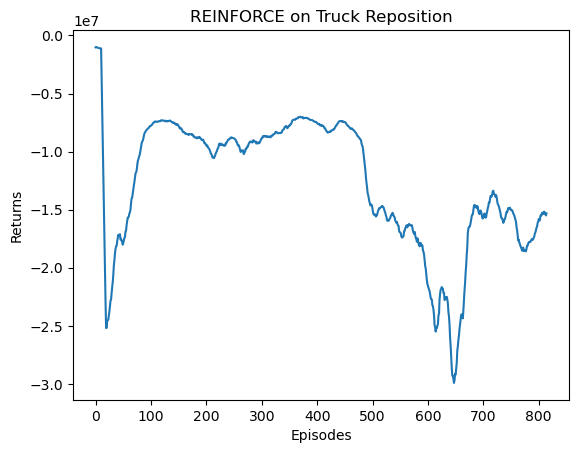

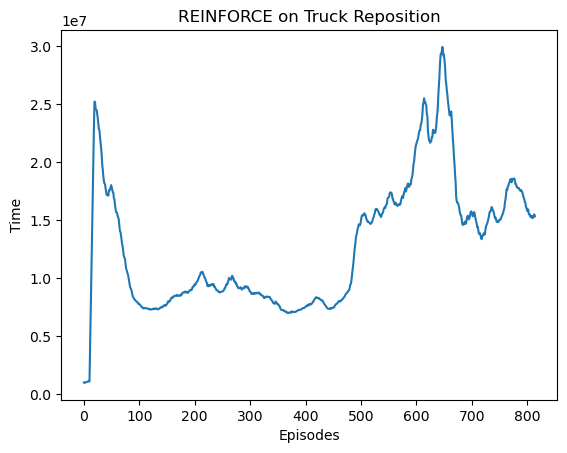

In [10]:
from matplotlib import pyplot as plt
import rl_utils

episodes_list = list(range(len(return_list)))

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(f'REINFORCE on Truck Reposition')
plt.show()


episodes_list = list(range(len(total_money_list)))

mv_return = rl_utils.moving_average(total_money_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Time')
plt.title(f'REINFORCE on Truck Reposition')
plt.show()

In [15]:
total_money_list[-10:]

[1022747.3600000007,
 942686.8800000007,
 982735.8400000008,
 982748.8000000007,
 1102753.1200000008,
 1022760.3200000008,
 1102757.4400000006,
 1022757.4400000008,
 1022676.8000000007,
 1022653.7600000008]

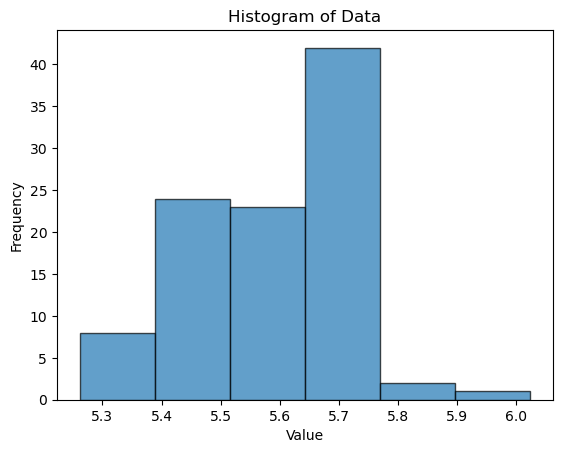

In [ ]:
import matplotlib.pyplot as plt



# 创建直方图
plt.hist(total_money_list[-100:], bins=6, edgecolor='black', alpha=0.7)

# 添加标题和标签
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示图形
plt.show()

In [ ]:
np.mean(total_money_list[-100:])

np.float64(5.585517295229172)

In [ ]:
from tqdm import tqdm
import torch
import os
from simulator import *

params_path = './model_params.pth'


learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 32
gamma = 0.98
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device(
    "cpu")

torch.manual_seed(0)

agent = REINFORCE(4, hidden_dim, learning_rate, gamma,device)

agent.scorenet.load_state_dict(torch.load(params_path))


episode_return = 0

env = Environment(128,4,running_day=1,start_date=datetime.datetime(2024,5,2))
Truck.id_count = 0

metric_list = []



for i in tqdm(range(10)):
    
    env.reset()

    stations_features,current_time,regu_reward,current_truck  = env.step()

    # state = env.reset()
    done = False
    while not done:
        
        stations = []
        features = []

        for s,feature in stations_features.items():
        
            stations.append(s)
            features.append(feature)
        
        action = agent.take_action_max_prob(features,len(stations))
        
        env.take_action(stations[action],current_truck)
        
        nxt_stations_features,nxt_time,regu_reward,nxt_truck  = env.step()
        
        
        if nxt_stations_features == None:
            done = True
        
        stations_features = nxt_stations_features
        current_truck = nxt_truck
        episode_return += regu_reward

    metric_list.append(env.count_time_per_fang())
    
    
    

/home/jiangrenchi/RL/ipykernel_2224651/2853264670.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.scorenet.load_state_dict(torch.load(params_path))
100%|█████████

In [22]:
metric_list

[6.869999398423871,
 6.869999398423871,
 6.869999398423871,
 6.869999398423871,
 6.869999398423871,
 6.869999398423871,
 6.869999398423871,
 6.869999398423871,
 6.869999398423871,
 6.869999398423871]

In [20]:
np.mean(metric_list)

np.float64(5.5773873662840625)

[6.682668591710281,
 6.691090657522709,
 6.696625157913734,
 6.775070685195211,
 6.76315947783192,
 6.64464898032846,
 6.7045659628225955,
 6.6647416230523975,
 6.796968056307525,
 6.683631113517416]

 np.float64(6.710317030620226)

In [10]:
np.mean(metric_list)

np.float64(5.605450144452253)

In [ ]:
6.708295734825242